In [1]:
#@title Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import matplotlib.pyplot as plt
import glob
import math
from pathlib import *
import re
import random
import copy
from tqdm.notebook import tqdm, trange
import gc
import datetime
import time
from torchvision import datasets, transforms

In [2]:
def free_gpu_cache():
# This function is used to clear the GPU cache and avoid memory problems when dealing with large populations and big models
    gc.collect()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

class FoodSource:
# The food sources will hold the models and represent the position in the hyperspace where the algorithm's agents are
    def __init__(self, net, fs_exhaustion_limit, lr, patience = 10):
        self.food = net # The food source's core is the model to be improved
        self.fs_exhaustion_limit = fs_exhaustion_limit # Number of times a food source can be exploited before considering it exhausted (local minimum)
        self.lr = lr
        self.patience = patience # Max epochs to be trained, unless the model starts overfitting
        self.optimizer = optim.Adam(self.food.parameters(), self.lr)

        self.fs_exhaustion = 0
        self.nectar = 0
        self.nectar_ev = [0]
        self.train_loss_ev = [0]
        self.val_loss_ev = [0]

    def mutate_feature_extractor(self, mut_amount = 1, max_layers = 150, max_k_size = 5, c_p_ratio = 5, reset_prob = 0.7, operations = ["add", "mut", "del", "res"], op_weights = [3, 3, 3, 1]):
    # This function takes a model and mutates its layer as to obtain a distinct but similar one
        deprecated = True

        while deprecated:
            #mut_amount = int(abs(np.random.normal(loc=1.0, scale=(1+self.fs_exhaustion)**1/3))+1)
            try:
                for m in range(mut_amount):
                    model_mutated = copy.deepcopy(self.food)
                    mut_type = random.choices(operations, weights = op_weights)[0]
                    features = 0
                    if mut_type == "add" and len(model_mutated.features) < max_layers:
                        self.add_layer(model_mutated, max_k_size, c_p_ratio)
                        features = 1
                    elif mut_type == "mut":
                        self.mut_layer(model_mutated, max_k_size)
                        features = 1
                    elif mut_type == "del" and len(model_mutated.features) > 2:
                        self.del_layer(model_mutated)
                        features = 1
                    elif mut_type == "cav":
                        self.change_avg_pool(model_mutated)
                        features = 1
                    elif mut_type == "res":
                        self.reset_weights(model_mutated, reset_prob)
                        features = 1
                    elif mut_type == "clr":
                        self.change_lr()

                self.prune_model(model_mutated)

                output_size = [0, model_mutated.avgpool.output_size[0], model_mutated.avgpool.output_size[1]]
                index = len(model_mutated.features)
                while output_size[0] == 0 and index > 0:
                    index -= 1
                    if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                        output_size[0] = model_mutated.features[index].out_channels

                for dim in output_size:
                    features = features*dim

                if features > 0:
                    deprecated = False
            except:
                deprecated = True

        model_mutated.classifier = nn.Sequential(torch.nn.modules.activation.ReLU(inplace = True),
                                                 nn.Linear(in_features=int(features), out_features=500, bias=True),
                                                 torch.nn.modules.activation.ReLU(inplace = True),
                                                 torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                                 nn.Linear(in_features=500, out_features=10, bias=True),nn.LogSoftmax(dim=1))
        self.food = copy.deepcopy(model_mutated)

    def prune_model(self, model_mutated, print_change = False):
    # This function makes sure that the model layers do not present incongruent patterns
        if print_change:
            print("Pruning model")
        
        index = 1
        condition = True
        while condition:
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                cl = "conv"
            elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
                cl = "pool"
            elif type(model_mutated.features[index]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index]) == torch.nn.Tanh or type(model_mutated.features[index]) == torch.nn.Sigmoid:
                cl = "act_fun"
            if type(model_mutated.features[index-1]) == torch.nn.modules.conv.Conv2d:
                pl = "conv"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index-1]) == torch.nn.modules.pooling.AvgPool2d:
                pl = "pool"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index-1]) == torch.nn.Tanh or type(model_mutated.features[index-1]) == torch.nn.Sigmoid:
                pl = "act_fun"
            
            if pl == "conv" and cl == "conv": # We add a ReLU between two consecutive conv layers
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], torch.nn.modules.activation.ReLU(inplace = True), *list(model_mutated.features.children())[index:])
                index = 0
            elif pl == "act_fun" and cl == "pool": # If an act function precedes a pooling layer, they are switched 
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], model_mutated.features[index], model_mutated.features[index-1], *list(model_mutated.features.children())[index+1:])
                index = 0
            elif pl == cl: # If two layers are the same (but not conv), the first one is removed
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], *list(model_mutated.features.children())[index:])
                index = 0
            index += 1
            condition = index < len(model_mutated.features)
    
    def change_lr(self, print_change = False):
        new_lr_min = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6]) # Gotta make this an input
        new_lr_range = random.choice([5, 10, 20]) # Gotta make this an input
        self.lrs = np.concatenate([np.linspace(new_lr_min, new_lr_min*new_lr_range, num = self.stepsize, endpoint = False), np.linspace(new_lr_min*new_lr_range, new_lr_min, num = self.stepsize, endpoint = False)])
        if print_change:
            print("Learning rate updated.")
    
    def change_avg_pool(self, model_mutated , print_change = False):
        max_out_size = 50 # Gotta make this an input
        model_mutated.avgpool = nn.AdaptiveAvgPool2d([random.randint(1, max_out_size), random.randint(1, max_out_size)])
        
    def add_layer(self, model_mutated, max_k_size, c_p_ratio, print_change = False):
        cw = 0.01
        pw = 0.01
        #afw = 0.01
        for layer in model_mutated.features:
            if type(layer) == torch.nn.modules.conv.Conv2d:
                cw += 1
            elif type(layer) == torch.nn.modules.pooling.MaxPool2d or type(layer) == torch.nn.modules.pooling.AvgPool2d:
                pw += 1
            #elif type(layer) == torch.nn.ReLU() or type(layer) == torch.nn.Tanh() or type(layer) == torch.nn.Sigmoid():
                #afw += 1
        layer_type = random.choices(["conv", "pool"], weights = [c_p_ratio/cw, 1/pw], k = 1)[0] # , "act_fun", 1/afw
        index = random.randint(1, len(model_mutated.features))

        if print_change:
            print("Inserting", layer_type, "at layer", index)
        if layer_type == "pool":
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                new_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                new_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)

        elif layer_type == "act_fun":
            new_layer = nn.ReLU()

        elif layer_type == "conv":
            dim = 0 # The inserted convolutional layer will have the same input feature maps as output ones as to fit within
            index_search = index
            while dim == 0:
                index_search -= 1
                if index_search < 0:
                    dim = 1
                    break
                if type(model_mutated.features[index_search]) == torch.nn.modules.conv.Conv2d:
                    dim = model_mutated.features[index_search].out_channels
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            new_layer = nn.Conv2d(dim, dim, kernel_size=k_size, stride=st, padding=pad)

        model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], new_layer, *list(model_mutated.features.children())[index:])

    def mut_layer(self, model_mutated, max_k_size, print_change = False):
        f_size_variab = 2

        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Mutating layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            dim_out = max(1, random.randint(int(model_mutated.features[index].out_channels/f_size_variab), min(int(model_mutated.features[index].out_channels*f_size_variab), 512)))
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            mut_layer = nn.Conv2d(dim_in, dim_out, kernel_size=k_size, stride=st, padding=pad)
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_out, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:])

        elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                mut_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                mut_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid:
            mut_layer = nn.ReLU()
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

    def del_layer(self, model_mutated, print_change = False):
        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Deleting layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_in, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:])

        # If it is a pooling or activation function layer we get rid of it directly
        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid or type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index_end:])

    def reset_weights(self, model_mutated, reset_prob, print_change = False): # Reinitialize the predictor's weights
        reseted_layers = []
        for index in range(len(model_mutated.features)):
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d and random.random() < reset_prob:
                reseted_layers += [index]
                nn.init.xavier_uniform_(model_mutated.features[index].weight.data, gain=nn.init.calculate_gain('relu'))
        if print_change:
            print("Weights reseted on layers", reseted_layers)
    
    def validate_fs(self):
    # This function is used to test the accuracy of a given model on the validation dataset
        total_loss = 0
        total_iter = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        self.food.eval()
        with tqdm(total=len(val_loader), leave = False, desc = "Checking current performance") as pbar:
            with torch.no_grad():
                for data in val_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.food(images).squeeze()
                    loss = criterion(outputs, labels)
                    total_iter += 1
                    total_loss += loss.item()
                    pbar.update(1)
        del images, labels, data, loss
        self.food.train()
        return total_loss / total_iter

In [3]:
def trainloop_weighted(fs, t_epochs, train_dloader, val_dloader, patience = 8, lr = 1e-3, show_plots=False):
    #This function is used to train a model for a certain number of epochs
    model = fs.food
    
    try:
        model.to(device)

        best_val = np.inf
        loss_tra = []
        loss_val = []
        overfit = 0
        lr = lr
        optimizer = optim.Adam(model.parameters(), lr)

        #with tqdm(total=t_epochs, leave = False, desc='Training') as pbar1:
        for epoch in range(t_epochs): # loop over the dataset multiple times
            running_loss = 0.0
            #with tqdm(total=len(train_dloader), leave = False, desc='Epoch progress') as pbar2:
            for i, data in enumerate(train_dloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                #pbar2.update(1)
            # We keep track of the losses and nectar evolutions
            loss_tra += [running_loss/len(train_dloader)]

            val_total_loss = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            model.eval()
            #with tqdm(total=len(val_dloader), leave = False, desc = "Checking model performance") as pbar:
            with torch.no_grad():
                for inputs, labels in val_dloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    val_total_loss += loss.item()
                    #pbar.update(1)
            model.train()
            loss_val += [val_total_loss / len(val_dloader)]
            #pbar1.update(1)

            if best_val > loss_val[-1]:
                best_model = copy.deepcopy(model)
                best_model.to("cpu")
                best_val = loss_val[-1]
                best_train = loss_tra[-1]
                overfit = 0
            else:
                overfit += 1

            if overfit >= patience:
                #pbar1.update(t_epochs)
                break

        model = copy.deepcopy(best_model)

        if show_plots == True:
            plt.plot(loss_val)
            plt.plot(loss_tra)
            plt.show()
            print()
            print("Best validation loss:       ", best_val)
            print("Corresponding training loss:", best_train)

        # We get rid of everything we don't need
        fs.nectar = fitness_function(best_val)

        del overfit, running_loss, i, data, optimizer, inputs, labels, loss #, pbar1, pbar2
        free_gpu_cache()
        invalid = False
    
    except:
        invalid = True
    
    fs.food = model
    
    return fs, invalid

In [4]:
def validate_ensemble(models, weights, dataloader, model_weighting = "mean"):
    # This
    equals = np.zeros(len(dataloader.dataset.targets))
    total_probs = np.zeros((len(dataloader.dataset.targets),10))
    with torch.no_grad():
        for m, model in enumerate(models):
            model.to(device)
            model.eval()
            probs = np.empty((0,10))
            for images,labels in dataloader:
                images,labels = images.to(device),labels.to(device)
                new_probs = torch.exp(model.forward(images)).cpu().numpy()
                probs = np.append(probs, new_probs, 0)
            probs_aux = np.zeros((len(dataloader.dataset.targets),10))
            for label in range(10):
                if model_weighting == "cm":
                    probs_aux[:,label] = probs@weights[m][:,label]
                else:
                    probs_aux = probs*weights[m]
            total_probs += probs_aux
            model.to("cpu")
            model.train()
        top_class = np.argmax(total_probs,1)
        equals = top_class == dataloader.dataset.targets
        
    return equals

In [5]:
#@title Bee classes and Nectar function
class EmployedBee:
# Each Employed Bee has an associated food source and will only exploit that one
    def __init__(self, fs, bee_number):
        self.fs = fs
        self.b_type = "employed"
        self.scouting = False
        self.bee_number = bee_number

    def exploit_food_source(self):
        try:
            invalid = True
            while invalid:
                new_fs = copy.deepcopy(self.fs)
                new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
                new_fs, invalid = trainloop_weighted(new_fs, 100, train_loader_weights, val_loader, patience = 8, lr = new_fs.lr, show_plots=False)

                if new_fs.nectar > self.fs.nectar: # If it is indeed better, the bee will change food source
                    self.fs = copy.deepcopy(new_fs)
                    self.fs.fs_exhaustion = 0
                    return 1
                else: # If not, the bee will forget about the new food source and add 1 to the exhaustion counter
                    self.fs.fs_exhaustion += 1
                    if self.fs.fs_exhaustion >= self.fs.fs_exhaustion_limit: # If the food source doesn't have any better ones nearby, it is considered a local minima
                        self.scouting = True
                    return 0
        except:
            return 0

class OnlookerBee:
# Onlooker bees will look at all current food sources and exploit the ones that look more promising
    def __init__(self, bee_number):
        self.b_type = "onlooker"
        self.bee_number = bee_number

    def scout_food_source(self, b_ffss, b_nectars):
        chosen_fs = True
        while chosen_fs: # If the random number generated does not match the probability of
            if random.random() > b_nectars[0]/sum(b_nectars): # the current food source being chosen,
                b_ffss = b_ffss[1:] + [b_ffss[0]] # we send that food source to the back of the list
                b_nectars = b_nectars[1:] + [b_nectars[0]]
            else:
                b_ffss = b_ffss[1:] + [b_ffss[0]]
                b_nectars = b_nectars[1:] + [b_nectars[0]]
                chosen_fs = False
        
        try:
            invalid = True
            while invalid:
                new_fs = copy.deepcopy(b_ffss[-1]) # If it does, we exploit it following the same procedure as for Employed Bees

                new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
                new_fs, invalid = trainloop_weighted(new_fs, 100, train_loader_weights, val_loader, patience = 8, lr = new_fs.lr, show_plots=False)

                if new_fs.nectar > b_ffss[0].nectar:
                    b_ffss[0] = copy.deepcopy(new_fs)
                    b_ffss[0].fs_exhaustion = 0
                    return 1, b_ffss, b_nectars
                else:
                    b_ffss[0].fs_exhaustion += 1
                    return 0, b_ffss, b_nectars
        except:
            return 0, b_ffss, b_nectars

def fitness_function(score):
# This is the fitness function to retrieve the nectar amount as defined for the ABC algorithm
    if score >= 0:
        fitness = 1 / (1 + score)
    else:
        fitness = 1 + abs(score)
    return fitness

In [6]:
def calculate_weights(model, dataloader):
    total_probs = np.zeros((len(dataloader.dataset.targets),10))
    model.to(device)
    model.eval()
    probs = np.empty((0,10))
    with torch.no_grad():
        for images,labels in dataloader:
            images,labels = images.to(device),labels.to(device)
            new_probs = torch.exp(model.forward(images)).cpu().numpy()
            probs = np.append(probs, new_probs, 0)
    model.to("cpu")
    model.train()
    top_class = np.argmax(probs,1)
    weights = np.zeros((10,10))
    # We generate the confussion matrix
    for i in range(10):
        for j in range(10):
            weights[i,j] = np.mean(top_class[np.array(dataloader.dataset.targets) == i]==j)
    return weights

In [7]:
#@title Beehive class (gotta define the model outside the class and call it)
class Beehive:
    def __init__(self, model, Np = 5, model_name = "[custom net]", fs_exhaustion_limit = 16, lr = 3e-3):
        
        self.bees = []
        self.ex_ffss = []
        self.ffss = []
        self.Np = Np
        free_gpu_cache()

        self.original_fs = FoodSource(net = model, fs_exhaustion_limit = fs_exhaustion_limit, lr = lr)
        self.original_fs, invalid = trainloop_weighted(self.original_fs, 100, train_loader_weights, val_loader, patience = 8, lr = self.original_fs.lr, show_plots=False)

        with tqdm(total=self.Np, leave = False, desc = "Initializing population") as pbar:
            for b in range(self.Np):
                invalid = True
                while invalid:
                    base_fs = copy.deepcopy(self.original_fs)
                    base_fs.mutate_feature_extractor(15)
                    base_fs, invalid = trainloop_weighted(base_fs, 100, train_loader_weights, val_loader, patience = 8, lr = base_fs.lr, show_plots=False)
                self.bees += [EmployedBee(copy.deepcopy(base_fs), b)]
                pbar.update(1)
        for b in range(self.Np):
            self.bees += [OnlookerBee(b)]

        self.current_iter = 0
    
    def find_foodsource(self, perf_thresh = 0, max_iter = 30):
        while self.current_iter < max_iter:
            self.current_iter += 1
            print("")
            print("Iteration", self.current_iter, "of the algorithm")
            nectars = []
                
            #print("Employed Bee Phase")
            b = 0
            c = 0
            self.ffss = []
            with tqdm(total=self.Np, leave = False, desc = "Employed bee phase") as pbar:
                for bee in self.bees:    # Employed bee phase
                    if bee.b_type == "employed":
                        b += 1
                        #print("    Employed Bee #" + str(b))
                        c += bee.exploit_food_source()
                        pbar.update(1)
                        if bee.fs.fs_exhaustion >= bee.fs.fs_exhaustion_limit:
                            bee.scouting = True
                        self.ffss += [bee.fs]
                        nectars += [bee.fs.nectar]
            print(c, "better food sources found during employed bee phase")
            
            #print("Onlooking Bee Phase")
            b = 0
            c = 0
            with tqdm(total=self.Np, leave = False, desc = "Onlooker bee phase") as pbar:
                for bee in self.bees:  # Scouting bee phase
                    if bee.b_type == "onlooker":
                        b += 1
                        #print("    Onlooker Bee #" + str(b))
                        a, self.ffss, nectars= bee.scout_food_source(self.ffss, nectars)
                        c += a
                        pbar.update(1)
            print(c, "better food sources found during onlooker bee phase")
            
            #print("Scouting Bee Phase")
            a = 0
            b = 0
            with tqdm(total=self.Np, leave = False, desc = "Scouting bee phase") as pbar:
                for bee in self.bees:    # Scouting bee phase
                    if bee.b_type == "employed":
                        bee.fs = self.ffss[a]
                        a += 1
                        pbar.update(1)
                        if bee.scouting:
                            b += 1
                            #print("    Scouting Bee #" + str(b)+ "reseted food source")
                            self.ex_ffss += [copy.deepcopy(bee.fs)]
                            invalid = True
                            while invalid:
                                base_fs = copy.deepcopy(self.original_fs)
                                base_fs.mutate_feature_extractor(15)
                                base_fs, invalid = trainloop_weighted(base_fs, 100, train_loader_weights, val_loader, patience = 8, lr = base_fs.lr, show_plots=False)
                            bee.fs = copy.deepcopy(base_fs)
                            bee.scouting = False
            if b == 0:
                print("No bees in scouting mode")
            else:
                print(c, "bees entered scouting mode")

        if self.current_iter == max_iter:
            print("Algorithm unable to find suitable food source in", self.current_iter, "iterations.")
    
        free_gpu_cache()
        return [copy.deepcopy(fs.food) for fs in self.ex_ffss + self.ffss]

    def save_models(self, folder = "saved_models\\", directory = os.getcwd()):
        os.chdir(directory)
        run_id = str(datetime.datetime.today())
        for i in range(len(run_id)):
            if run_id[i] == "-" or run_id[i] == " " or run_id[i] == ":":
                run_id = run_id[:i]+"_"+run_id[i+1:]
            elif run_id[i] == ".":
                run_id = run_id[:i]
                break
        model_save_path = folder+run_id
        if not os.path.exists(model_save_path):
          os.makedirs(model_save_path)

        models = [bee.fs for bee in self.bees[:self.Np]] + self.ex_ffss
        for i in range(len(models)):
            model = copy.deepcopy(models[i])
            torch.save(model.food, model_save_path+"\\"+str(np.mean(model.val_loss_ev[-4:]))+".pt")

        del model, models

In [8]:
def save_model(model, name, folder = "saved_models\\"):
    
    if not os.path.exists(folder):
      os.makedirs(folder)

    torch.save(model, folder+"\\"+name+".pt")

In [9]:
n_hives = 4
max_iter_hive = 16
Np = 4
criterion = nn.NLLLoss()
data_weighting = "fail_resample"
model_weighting = "val_weight"
save_models = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU available:", device == torch.device('cuda'))

# Download and load the training data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=False)
val_loader = copy.deepcopy(train_loader)
# Permutate dataset for crossvalidation
idx_shuffled = np.arange(len(train_loader.dataset.targets))
np.random.shuffle(idx_shuffled)

#We take 45k random images for training
train_loader.dataset.data = train_loader.dataset.data[idx_shuffled[:45000],:,:]
train_loader.dataset.targets = [train_loader.dataset.targets[idx] for idx in idx_shuffled[:45000]]

# We create another one that suffles, is subjected to change and holds the weights of the datapoints
train_loader_weights = torch.utils.data.DataLoader(copy.deepcopy(train_loader.dataset), batch_size=64, shuffle=True)

#And the rest for validation
val_loader.dataset.data = val_loader.dataset.data[idx_shuffled[45000:],:,:]
val_loader.dataset.targets = [val_loader.dataset.targets[idx] for idx in idx_shuffled[45000:]]

# Fetch the test data as well
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

# We generate the base model to start the evolution from.
#This can be just a single convolutional layer and a single fully connected, but they need to be inside a "features" and a "classifier" nn.Sequential respectively.
model = torch.hub.load('pytorch/vision:v0.10.0', "vgg11", weights="VGG11_Weights.IMAGENET1K_V1")
model.features = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
model.avgpool = nn.AdaptiveAvgPool2d([10, 10])

output_size = [0, model.avgpool.output_size[0], model.avgpool.output_size[1]]
index = len(model.features)
while output_size[0] == 0:
    index -= 1
    if type(model.features[index]) == torch.nn.modules.conv.Conv2d:
        output_size[0] = model.features[index].out_channels

features = 1
for dim in output_size:
    features = features*dim

model.classifier = nn.Sequential(nn.Linear(in_features=int(features), out_features=500, bias=True),
                                        torch.nn.modules.activation.ReLU(inplace = True),
                                        torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                        nn.Linear(in_features=500, out_features=10, bias=True), 
                                        nn.LogSoftmax(dim=1))

# Generate folder to save run
folder_path = "D:\\adri\\iisgm\\2022_2023\\saved_models_Deepsemble\\CIFAR100_Chimera_"+data_weighting+"_"+model_weighting
run_id = str(datetime.datetime.today())
for i in range(len(run_id)):
    if run_id[i] == "-" or run_id[i] == ":":
        run_id = run_id[:i]+"_"+run_id[i+1:]
    elif run_id[i] == " ":
        run_id = run_id[:i]
        break
folder_path = folder_path+run_id+"_0"

i = 0
while os.path.exists(folder_path):
    i += 1
    folder_path = folder_path[:-2]+"_"+str(i)

# Generate models
models_list = []
model_weights = []
model_acc = []
t_acc = np.empty((0,0))
v_acc = np.empty((0,0))
test_acc = np.empty((0,0))

for n in range(n_hives):
    start_time = time.time()
    hive = Beehive(model = model, Np = Np, model_name = "[VGG11ev]", fs_exhaustion_limit = 16, lr = 3e-3)
    model_batch = hive.find_foodsource(perf_thresh = 0, max_iter = max_iter_hive)
    
    print(len(model_batch), "models added to the ensemble in", time.time()-start_time, "seconds")
    
    for m, model in enumerate(model_batch):
        save_model(model, name = str(len(models_list)+m), folder = folder_path)
        model_weights += [calculate_weights(model, val_loader)]
        model_acc += [np.sum(np.diagonal(model_weights[-1]))/np.sum(model_weights[-1])]
        
    models_list += model_batch

    # Calculate performances on the datasets
    if model_weighting == "mean":
        train_equals = validate_ensemble(models_list, np.ones(len(model_acc)), train_loader, model_weighting = model_weighting)
        t_acc = np.append(t_acc, np.mean(train_equals))
        v_acc = np.append(v_acc, np.mean(validate_ensemble(models_list, np.ones(len(model_acc)), val_loader, model_weighting = model_weighting)))
        test_acc = np.append(test_acc, np.mean(validate_ensemble(models_list, np.ones(len(model_acc)), test_loader, model_weighting = model_weighting)))
    elif model_weighting == "val_weight":
        train_equals = validate_ensemble(models_list, model_acc, train_loader, model_weighting = model_weighting)
        t_acc = np.append(t_acc, np.mean(train_equals))
        v_acc = np.append(v_acc, np.mean(validate_ensemble(models_list, model_acc, val_loader, model_weighting = model_weighting)))
        test_acc = np.append(test_acc, np.mean(validate_ensemble(models_list, model_acc, test_loader, model_weighting = model_weighting)))
    elif model_weighting == "cm":
        train_equals = validate_ensemble(models_list, model_weights, train_loader, model_weighting = model_weighting)
        t_acc = np.append(t_acc, np.mean(train_equals))
        v_acc = np.append(v_acc, np.mean(validate_ensemble(models_list, model_weights, val_loader, model_weighting = model_weighting)))
        test_acc = np.append(test_acc, np.mean(validate_ensemble(models_list, model_weights, test_loader, model_weighting = model_weighting)))

    # Resample or weight the dataset
    if data_weighting == "fail_resample":
        train_loader_updated = torch.utils.data.DataLoader(copy.deepcopy(train_loader.dataset), batch_size=64, shuffle=True)
        train_loader_updated.dataset.data = train_loader_updated.dataset.data[~train_equals,:,:]
        train_loader_updated.dataset.targets = [train_loader_updated.dataset.targets[idx] for idx in np.arange(len(train_equals))[~train_equals]]
    elif data_weighting == "acc_resample":
        weights = np.ones(len(train_loader.dataset.targets))
        weights = weights*np.exp(1-(2*train_equals)*np.mean(train_equals))
        weights /= np.sum(weights) # Normalize
        new_indexes = np.random.choice([int(d) for d in range(len(weights))], len(weights), p=weights)
        train_loader_updated = copy.deepcopy(train_loader)
        train_loader_updated.dataset.data = train_loader.dataset.data[new_indexes,:,:]
        train_loader_updated.dataset.targets = [train_loader.dataset.targets[i]for i in new_indexes]
    elif data_weighting == "data_weights":
        total_train_acc = np.sum(train_equals)/len(train_equals)
        weights = np.exp((1-(2*train_equals))*total_train_acc)
        weights = weights/np.mean(weights)
        train_loader_weights.dataset.targets[:,1] = weights

# We order the models according to their validation accuracy
model_acc = []
for con_matrix in model_weights:
    model_acc += [np.sum(np.diagonal(con_matrix))/np.sum(con_matrix)]
indexes_sorted = np.flip(np.argsort(model_acc))


GPU available: True
Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\agomez/.cache\torch\hub\pytorch_vision_v0.10.0


Initializing population:   0%|          | 0/4 [00:00<?, ?it/s]


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 14 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 15 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 16 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode
Algorithm unable to find suitable food source in 16 iterations.
4 models added to the ensemble in 15749.684014081955 seconds


Initializing population:   0%|          | 0/4 [00:00<?, ?it/s]


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

3 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 bees entered scouting mode

Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 14 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 15 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 16 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode
Algorithm unable to find suitable food source in 16 iterations.
5 models added to the ensemble in 13503.831882476807 seconds


Initializing population:   0%|          | 0/4 [00:00<?, ?it/s]


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

3 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 14 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 15 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 16 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode
Algorithm unable to find suitable food source in 16 iterations.
4 models added to the ensemble in 13252.846149682999 seconds


Initializing population:   0%|          | 0/4 [00:00<?, ?it/s]


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 bees entered scouting mode

Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 bees entered scouting mode

Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 14 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 15 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode

Iteration 16 of the algorithm


Employed bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/4 [00:00<?, ?it/s]

No bees in scouting mode
Algorithm unable to find suitable food source in 16 iterations.
6 models added to the ensemble in 11773.702964782715 seconds


max_ensemble_train = [0.9721777777777778]
max_ensemble_val = [0.8238]
max_ensemble_test = [0.8218]
max_sorted_train = [0.9888888888888889]
max_sorted_val = [0.8246]
max_sorted_test = [0.8226]


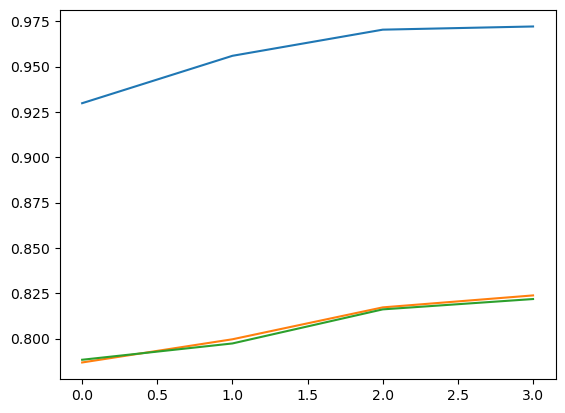

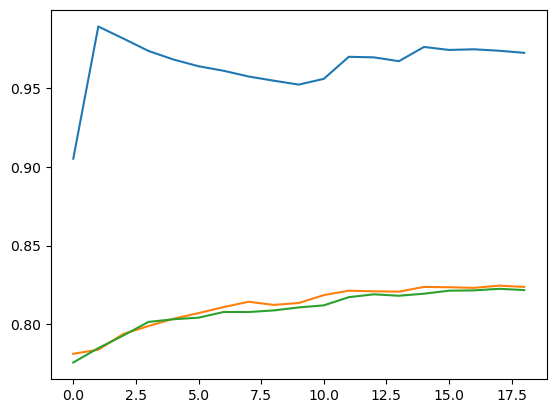

t_acc =0.95711 ± 0.01695
v_acc =0.80685 ± 0.01457
test_acc =0.80588 ± 0.01361
t_acc_sorted =0.96507 ± 0.01686
v_acc_sorted =0.81165 ± 0.01318
test_acc_sorted =0.80906 ± 0.01273


In [10]:
t_acc_sorted = np.empty((0,0))
v_acc_sorted = np.empty((0,0))
test_acc_sorted = np.empty((0,0))
#with tqdm(total=len(models_list), leave = False, desc = "Calculating ensemble performance evolution") as pbarm:
for n in range(len(models_list)):
    if model_weighting == "mean":
        t_acc_sorted = np.append(t_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], np.ones(n+1), train_loader, model_weighting = model_weighting)))
        v_acc_sorted = np.append(v_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], np.ones(n+1), val_loader, model_weighting = model_weighting)))
        test_acc_sorted = np.append(test_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], np.ones(n+1), test_loader, model_weighting = model_weighting)))
    elif model_weighting == "val_weight":
        t_acc_sorted = np.append(t_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_acc[m] for m in indexes_sorted[:n+1]], train_loader, model_weighting = model_weighting)))
        v_acc_sorted = np.append(v_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_acc[m] for m in indexes_sorted[:n+1]], val_loader, model_weighting = model_weighting)))
        test_acc_sorted = np.append(test_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_acc[m] for m in indexes_sorted[:n+1]], test_loader, model_weighting = model_weighting)))
    elif model_weighting == "cm":
        t_acc_sorted = np.append(t_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_weights[m] for m in indexes_sorted[:n+1]], train_loader, model_weighting = model_weighting)))
        v_acc_sorted = np.append(v_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_weights[m] for m in indexes_sorted[:n+1]], val_loader, model_weighting = model_weighting)))
        test_acc_sorted = np.append(test_acc_sorted, np.mean(validate_ensemble([models_list[m] for m in indexes_sorted[:n+1]], [model_weights[m] for m in indexes_sorted[:n+1]], test_loader, model_weighting = model_weighting)))
    #pbarm.update(1)


max_ensemble_train = [max(t_acc)]
max_ensemble_val   = [max(v_acc)]
max_ensemble_test  = [max(test_acc)]
max_sorted_train   = [max(t_acc_sorted)]
max_sorted_val     = [max(v_acc_sorted)]
max_sorted_test    = [max(test_acc_sorted)]
print("max_ensemble_train =", max_ensemble_train)
print("max_ensemble_val =", max_ensemble_val)
print("max_ensemble_test =", max_ensemble_test)
print("max_sorted_train =", max_sorted_train)
print("max_sorted_val =", max_sorted_val)
print("max_sorted_test =", max_sorted_test)

plt.plot(t_acc)
plt.plot(v_acc)
plt.plot(test_acc)
plt.show()
plt.plot(t_acc_sorted)
plt.plot(v_acc_sorted)
plt.plot(test_acc_sorted)
plt.show()

print("t_acc =" + f"{np.mean(t_acc):.5f}" + " ± " + f"{np.std(t_acc):.5f}")
print("v_acc =" + f"{np.mean(v_acc):.5f}" + " ± " + f"{np.std(v_acc):.5f}")
print("test_acc =" + f"{np.mean(test_acc):.5f}" + " ± " + f"{np.std(test_acc):.5f}")
print("t_acc_sorted =" + f"{np.mean(t_acc_sorted):.5f}" + " ± " + f"{np.std(t_acc_sorted):.5f}")
print("v_acc_sorted =" + f"{np.mean(v_acc_sorted):.5f}" + " ± " + f"{np.std(v_acc_sorted):.5f}")
print("test_acc_sorted =" + f"{np.mean(test_acc_sorted):.5f}" + " ± " + f"{np.std(test_acc_sorted):.5f}")